2485 tracks after merging audio features and extras.


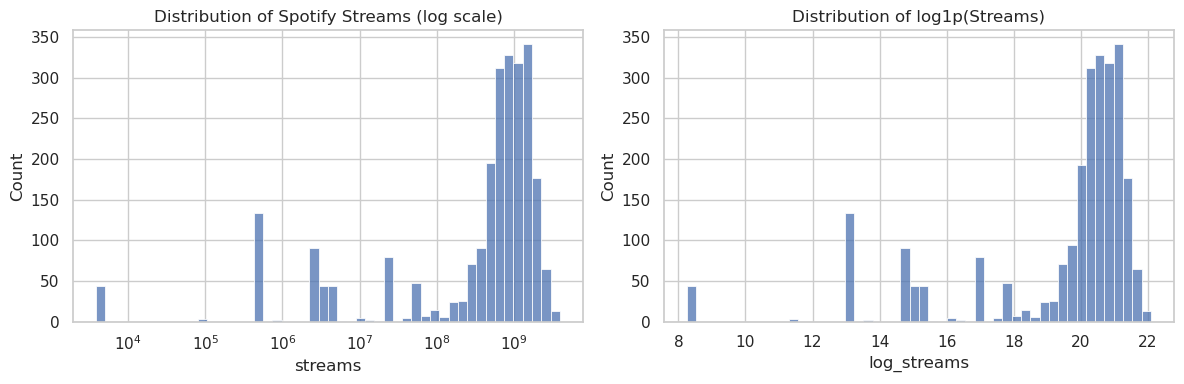

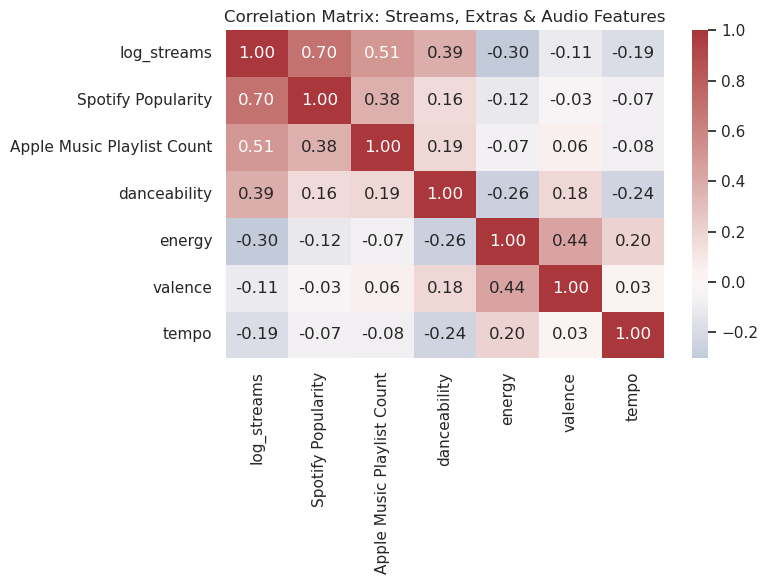

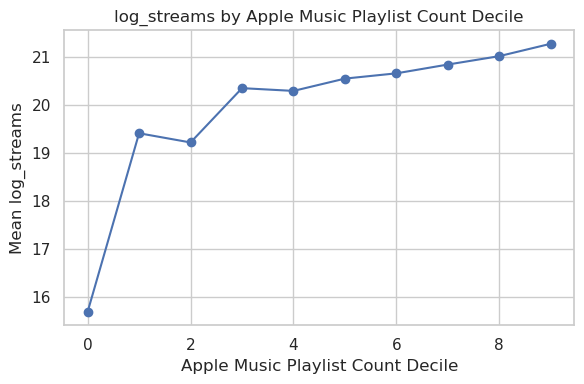

Best Params: {'hgb__max_iter': 200, 'hgb__max_depth': 3, 'hgb__learning_rate': 0.2}
Best CV R²: 0.574
Final Pipeline CV R² on train: 0.811 ± 0.041
Final Test R²:  0.858
Final Test RMSE: 1.057


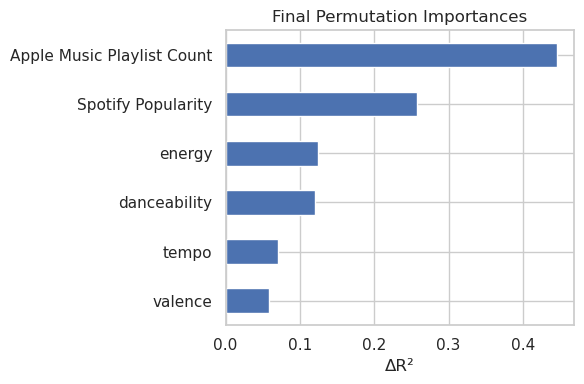

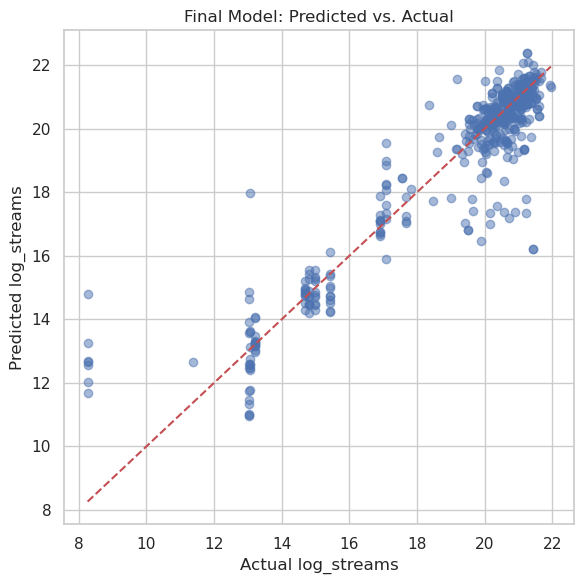

In [1]:
# %%
# 🎵 Spotify Streams Predictive Analysis
# Refactored, consolidated notebook with EDA, hyperparameter search, and final pipeline

# 1. Setup & Imports
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline         import Pipeline, make_pipeline
from sklearn.impute           import SimpleImputer
from sklearn.preprocessing    import StandardScaler
from sklearn.ensemble         import HistGradientBoostingRegressor
from sklearn.model_selection  import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.inspection       import permutation_importance
from sklearn.metrics          import r2_score, mean_squared_error

sns.set(style="whitegrid")

# %%
# 2. Helper Functions

def normalize_key(artist: str, track: str) -> str:
    """Create a normalized merge key from artist and track names."""
    s = f"{artist or ''} - {track or ''}".lower()
    s = re.sub(r"\s*\(.*?\)", "", s)
    s = re.sub(r"[^a-z0-9 ]+", " ", s)
    return re.sub(r"\s+", " ", s).strip()


def load_and_prepare(streams_csv: str, features_csv: str) -> pd.DataFrame:
    """
    Load Spotify streams + extras and audio features, merge, clean, and return
    a DataFrame with:
      ['Spotify Popularity', 'Apple Music Playlist Count',
       'danceability','energy','valence','tempo','log_streams'] plus extras
    """
    # --- Streams & Extras ---
    df = pd.read_csv(streams_csv, encoding='latin-1')
    df['streams'] = pd.to_numeric(
        df['Spotify Streams'].str.replace(',', ''), errors='coerce'
    )
    df.dropna(subset=['streams'], inplace=True)
    df['log_streams'] = np.log1p(df['streams'])
    # Extras:
    df['Spotify Popularity'] = pd.to_numeric(df['Spotify Popularity'], errors='coerce')
    df['Apple Music Playlist Count'] = pd.to_numeric(
        df['Apple Music Playlist Count'].astype(str).str.replace(',', ''), errors='coerce'
    )
    # Merge key
    df['key'] = df.apply(
        lambda r: normalize_key(r['Artist'], r['Track']), axis=1
    )

    # --- Audio Features ---
    feat = pd.read_csv(features_csv, usecols=[
        'artist_name','track_name','danceability','energy','valence','tempo'
    ])
    feat['key'] = feat.apply(
        lambda r: normalize_key(r['artist_name'], r['track_name']), axis=1
    )

    # --- Merge & Clean ---
    dfm = (
        df.merge(
            feat[['key','danceability','energy','valence','tempo']],
            on='key', how='left'
        )
        .dropna(subset=['danceability','energy','valence','tempo'])
        .reset_index(drop=True)
    )
    return dfm


# %%
# 3. Load & Prepare Data
STREAMS_CSV  = 'Most Streamed Spotify Songs 2024.csv'
FEATURES_CSV = 'SpotifyFeatures.csv'

dfm = load_and_prepare(STREAMS_CSV, FEATURES_CSV)
print(f"{len(dfm)} tracks after merging audio features and extras.")

# %%
# 4. Exploratory Data Analysis (EDA)

# 4.1 Distributions
fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.histplot(dfm['streams'], log_scale=True, bins=50, ax=axes[0])
axes[0].set_title('Distribution of Spotify Streams (log scale)')
sns.histplot(dfm['log_streams'], bins=50, ax=axes[1])
axes[1].set_title('Distribution of log1p(Streams)')
plt.tight_layout()
plt.show()

# 4.2 Correlation Heatmap
cols = ['log_streams','Spotify Popularity','Apple Music Playlist Count',
        'danceability','energy','valence','tempo']
corr = dfm[cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='vlag', center=0)
plt.title('Correlation Matrix: Streams, Extras & Audio Features')
plt.tight_layout()
plt.show()

# 4.3 Decile Plot for Apple Music Playlist Count

dfm['decile_apple'] = pd.qcut(dfm['Apple Music Playlist Count'], 10, labels=False)
st = dfm.groupby('decile_apple')['log_streams'].mean()
plt.figure(figsize=(6,4))
st.plot(marker='o')
plt.xlabel('Apple Music Playlist Count Decile')
plt.ylabel('Mean log_streams')
plt.title('log_streams by Apple Music Playlist Count Decile')
plt.tight_layout()
plt.show()

# %%
# 5. Hyperparameter Search (Randomized)

PREDICTORS = ['Spotify Popularity','Apple Music Playlist Count',
              'danceability','energy','valence','tempo']
X = dfm[PREDICTORS]
y = dfm['log_streams']

pipe_search = Pipeline([
    ('imp',   SimpleImputer(strategy='median')),
    ('scale', StandardScaler()),
    ('hgb',   HistGradientBoostingRegressor(random_state=0))
])

param_dist = {
    'hgb__max_iter':      [100,200,300],
    'hgb__learning_rate': [0.01,0.1,0.2],
    'hgb__max_depth':     [3,5,10],
}

search = RandomizedSearchCV(
    pipe_search, param_dist,
    n_iter=10, cv=5, scoring='r2', random_state=0, n_jobs=-1
)
search.fit(X, y)
print("Best Params:", search.best_params_)
print("Best CV R²:", round(search.best_score_,3))

# %%
# 6. Final Pipeline + Evaluation

# 6.1 Hold-out split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

# 6.2 Build final pipeline with tuned hyperparameters
best = search.best_params_
final_pipe = Pipeline([
    ('imp',   SimpleImputer(strategy='median')),
    ('scale', StandardScaler()),
    ('hgb',   HistGradientBoostingRegressor(
                  max_iter=best['hgb__max_iter'],
                  learning_rate=best['hgb__learning_rate'],
                  max_depth=best['hgb__max_depth'],
                  random_state=0
              ))
])

# 6.3 Cross-validated performance on train
cv_scores = cross_val_score(final_pipe, X_train, y_train, cv=5,
                            scoring='r2', n_jobs=-1)
print(f"Final Pipeline CV R² on train: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# 6.4 Fit & Predict
final_pipe.fit(X_train, y_train)
y_pred = final_pipe.predict(X_test)

# 6.5 Metrics
r2_test   = r2_score(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Final Test R²:  {r2_test:.3f}")
print(f"Final Test RMSE: {rmse_test:.3f}")

# 6.6 Permutation Importances on full data
perm = permutation_importance(
    final_pipe, X, y, n_repeats=10, random_state=0, scoring='r2', n_jobs=-1
)
imp = pd.Series(perm.importances_mean, index=PREDICTORS).sort_values()

plt.figure(figsize=(6,4))
imp.plot.barh()
plt.title('Final Permutation Importances')
plt.xlabel('ΔR²')
plt.tight_layout()
plt.show()

# 6.7 Predicted vs. Actual Scatter
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual log_streams')
plt.ylabel('Predicted log_streams')
plt.title('Final Model: Predicted vs. Actual')
plt.tight_layout()
plt.show()


In [2]:
# berechne die Decil-Grenzwerte
decile_edges = dfm['Apple Music Playlist Count'].quantile(np.arange(0, 1.1, 0.1)).to_dict()
print("Decile-Grenzwerte (Count → Playlist-Count):")
for dec, val in decile_edges.items():
    print(f"  {int(dec*10)} %: {val:.0f} Plays")


Decile-Grenzwerte (Count → Playlist-Count):
  0 %: 1 Plays
  1 %: 3 Plays
  2 %: 18 Plays
  3 %: 30 Plays
  4 %: 47 Plays
  5 %: 66 Plays
  6 %: 88 Plays
  7 %: 114 Plays
  8 %: 148 Plays
  9 %: 206 Plays
  10 %: 550 Plays
